In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import xarray as xr
import rioxarray as rxr
from shapely import Point, MultiPoint, wkt
import regex as re
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle


# Data Cleaning and Collation

## Weather Data

Load data into dataframe and exclude preciptation information. Then check how the dataframe looks.

In [2]:
with open('data/weather_data.csv', 'r', encoding='latin1') as f:
    weather_df=pd.read_csv(f)
    
filter = (weather_df['Type'] != 'precipitation')
weather_df = weather_df[filter]
weather_df.head()

,Collected,Location,Type,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,...,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
0,2020-07-22 13:52:42.276127,Wellington,high,14.0,11.0,14.0,12.0,12.0,13.0,13.0,...,14.0,12.0,14.0,14.0,15.0,15.0,15.0,14.0,13.0,14
1,2020-07-22 13:52:42.276127,Wellington,low,11.0,7.0,7.0,6.0,7.0,8.0,8.0,...,7.0,7.0,9.0,9.0,9.0,9.0,7.0,7.0,8.0,7
3,2020-07-22 13:52:53.784032,Auckland,high,16.0,14.0,16.0,14.0,14.0,14.0,14.0,...,14.0,15.0,15.0,16.0,17.0,16.0,16.0,16.0,15.0,16
4,2020-07-22 13:52:53.784032,Auckland,low,10.0,10.0,10.0,8.0,7.0,7.0,9.0,...,10.0,10.0,11.0,11.0,10.0,11.0,9.0,10.0,11.0,10
6,2020-07-22 13:53:10.735065,Sydney,high,18.0,19.0,18.0,18.0,18.0,15.0,16.0,...,18.0,18.0,18.0,19.0,22.0,20.0,20.0,18.0,20.0,18


Reformat strings to datetime, and create multi-index for location, collection date and high/low temperatures.

In [3]:
weather_df['Collected']=pd.to_datetime(weather_df['Collected'], format='%Y-%m-%d %H:%M:%S.%f')
weather_df['Collected'] = weather_df['Collected'].dt.floor('d')
weather_df = weather_df.set_index(['Location', 'Collected','Type'])
weather_df.columns = pd.to_datetime(weather_df.columns, format='%Y-%m-%d')
weather_df.head()

2020-07-21  2020-07-22  2020-07-23  2020-07-24  \
Location   Collected  Type                                                   
Wellington 2020-07-22 high        14.0        11.0        14.0        12.0   
                      low         11.0         7.0         7.0         6.0   
Auckland   2020-07-22 high        16.0        14.0        16.0        14.0   
                      low         10.0        10.0        10.0         8.0   
Sydney     2020-07-22 high        18.0        19.0        18.0        18.0   

                            2020-07-25  2020-07-26  2020-07-27  2020-07-28  \
Location   Collected  Type                                                   
Wellington 2020-07-22 high        12.0        13.0        13.0        13.0   
                      low          7.0         8.0         8.0         8.0   
Auckland   2020-07-22 high        14.0        14.0        14.0        14.0   
                      low          7.0         7.0         9.0        12.0   
Sydney     2020-07-22 high        18.0        15.0        16.0        16.0   

                            2020-07-29  2020-07-30  ...  2020-08-22  \
Location   Collected  Type                          ...               
Wellington 2020-07-22 high        14.0        14.0  ...        14.0   
                      low         10.0         9.0  ...         7.0   
Auckland   2020-07-22 high        16.0        16.0  ...        14.0   
                      low         10.0        10.0  ...        10.0   
Sydney     2020-07-22 high        19.0        18.0  ...        18.0   

                            2020-08-23  2020-08-24  2020-08-25  2020-08-26  \
Location   Collected  Type                                                   
Wellington 2020-07-22 high        12.0        14.0        14.0        15.0   
                      low          7.0         9.0         9.0         9.0   
Auckland   2020-07-22 high        15.0        15.0        16.0        17.0   
                      low         10.0        11.0        11.0        10.0   
Sydney     2020-07-22 high        18.0        18.0        19.0        22.0   

                            2020-08-27  2020-08-28  2020-08-29  2020-08-30  \
Location   Collected  Type                                                   
Wellington 2020-07-22 high        15.0        15.0        14.0        13.0   
                      low          9.0         7.0         7.0         8.0   
Auckland   2020-07-22 high        16.0        16.0        16.0        15.0   
                      low         11.0         9.0        10.0        11.0   
Sydney     2020-07-22 high        20.0        20.0        18.0        20.0   

                            2020-08-31  
Location   Collected  Type              
Wellington 2020-07-22 high          14  
                      low            7  
Auckland   2020-07-22 high          16  
                      low           10  
Sydney     2020-07-22 high          18  

[5 rows x 42 columns]

We need to clean the data to ensure there are no duplicates where we have collected twice on the same day. We can see that there is a relatively minute amount of duplicates

In [4]:
# Check duplicate count
dup_perc = weather_df[weather_df.index.duplicated()].shape[0] / weather_df.shape[0] * 100
print(f"old duplicate percentage = {dup_perc:.2f}%")

# Remove duplicates
weather_df = weather_df[~weather_df.index.duplicated()]
dup_perc = weather_df[weather_df.index.duplicated()].shape[0] / weather_df.shape[0] * 100
print(f"new duplicate percentage = {dup_perc:.2f}%")


old duplicate percentage = 0.09%
new duplicate percentage = 0.00%


### Create 'time delta' dataframe and mask functions

We wish to find how accurate forecasts are based on distance from forecast date. Hence, we are interested in the difference between collection date (which is part of the index), and the forecasted day (columns). Once we have established this, we can create masks which will return the relevant data.

In [5]:
column_values = weather_df.columns.values
index_values_full = weather_df.index.get_level_values(1).values
time_deltas_with_duplicates = (column_values[np.newaxis,:] - index_values_full[:,np.newaxis])
time_deltas_with_duplicates = time_deltas_with_duplicates.astype('timedelta64[D]')
time_deltas_df = pd.DataFrame(time_deltas_with_duplicates, index=weather_df.index, columns=weather_df.columns)
time_deltas_df.head()

# # Currently unused. Can we make use of the below for a more efficient representation?
# index_values = weather_df.index.get_level_values(1).drop_duplicates().values
# time_deltas = (column_values[np.newaxis,:] - index_values[:,np.newaxis]).astype('timedelta64[D]')

2020-07-21 2020-07-22 2020-07-23 2020-07-24  \
Location   Collected  Type                                               
Wellington 2020-07-22 high    -1 days     0 days     1 days     2 days   
                      low     -1 days     0 days     1 days     2 days   
Auckland   2020-07-22 high    -1 days     0 days     1 days     2 days   
                      low     -1 days     0 days     1 days     2 days   
Sydney     2020-07-22 high    -1 days     0 days     1 days     2 days   

                           2020-07-25 2020-07-26 2020-07-27 2020-07-28  \
Location   Collected  Type                                               
Wellington 2020-07-22 high     3 days     4 days     5 days     6 days   
                      low      3 days     4 days     5 days     6 days   
Auckland   2020-07-22 high     3 days     4 days     5 days     6 days   
                      low      3 days     4 days     5 days     6 days   
Sydney     2020-07-22 high     3 days     4 days     5 days     6 days   

                           2020-07-29 2020-07-30  ... 2020-08-22 2020-08-23  \
Location   Collected  Type                        ...                         
Wellington 2020-07-22 high     7 days     8 days  ...    31 days    32 days   
                      low      7 days     8 days  ...    31 days    32 days   
Auckland   2020-07-22 high     7 days     8 days  ...    31 days    32 days   
                      low      7 days     8 days  ...    31 days    32 days   
Sydney     2020-07-22 high     7 days     8 days  ...    31 days    32 days   

                           2020-08-24 2020-08-25 2020-08-26 2020-08-27  \
Location   Collected  Type                                               
Wellington 2020-07-22 high    33 days    34 days    35 days    36 days   
                      low     33 days    34 days    35 days    36 days   
Auckland   2020-07-22 high    33 days    34 days    35 days    36 days   
                      low     33 days    34 days    35 days    36 days   
Sydney     2020-07-22 high    33 days    34 days    35 days    36 days   

                           2020-08-28 2020-08-29 2020-08-30 2020-08-31  
Location   Collected  Type                                              
Wellington 2020-07-22 high    37 days    38 days    39 days    40 days  
                      low     37 days    38 days    39 days    40 days  
Auckland   2020-07-22 high    37 days    38 days    39 days    40 days  
                      low     37 days    38 days    39 days    40 days  
Sydney     2020-07-22 high    37 days    38 days    39 days    40 days  

[5 rows x 42 columns]

A quick sanity check

In [6]:
time_deltas_with_duplicates.shape == weather_df.shape

True

We can now use the time_deltas dataframe to create masks for a fixed distances between date of collection and forecasted date.

In [7]:
def create_df_mask(day_diff):

    is_int = isinstance(day_diff, int)
    is_time_delta = isinstance(day_diff, np.timedelta64)

    assert is_int or is_time_delta, "day_diff argument must be integer or np.timedelta64"
    
    day_diff = np.timedelta64(day_diff, 'D')
    mask = (time_deltas_df == day_diff)
    
    return mask

def create_df_mask_range(min_diff, max_diff):
    masks = []
    for day_diff in range(min_diff, max_diff+1):
        masks.append(create_df_mask(day_diff))
    return np.logical_or.reduce(masks)    

### Find true temperatures and deviation from true temperatures

It is then possible to create series to capture temperatures on a given date as predicted day_diff days ago; that is, rather than representing the collection date, the date in the index will now represent the forecasted day.

In [8]:
def get_predicted_temperatures(day_diff):
    predicted_temps = weather_df[create_df_mask(day_diff)]
    predicted_temps = predicted_temps.stack().droplevel('Collected')
    predicted_temps.index = predicted_temps.index.set_names(['Location', 'Type', 'Date'])
    predicted_temps.swaplevel(1,2)

    return predicted_temps


To view how this data is formatted, if we look at temperatures as predicted 30 days in the past, we find that the dates begin on 2020-08-21, 30 days in from the day collection started (2020-07-22).

In [9]:
get_predicted_temperatures(30).head()

Location    Type  Date      
Wellington  high  2020-08-21    12.0
            low   2020-08-21     8.0
Auckland    high  2020-08-21    14.0
            low   2020-08-21    10.0
Sydney      high  2020-08-21    18.0
dtype: float64

I choose to define the true temperature for a day as the recorded result when checking from the following day (i.e. the true temperature for 2020-07-22, is given by checking on 2020-07-23). It is then possible to define the absolute deviation.

In [10]:
true_temperatures = get_predicted_temperatures(-1)
def find_deviation(day_diff):
    return (get_predicted_temperatures(day_diff)-true_temperatures).dropna()

def find_abs_deviation(day_diff):
    return np.abs(find_deviation(day_diff))

If this is completely reliable, then checking any number of days in the past should yield no deviation with the above result, unfortunately this is not the case. 

In [11]:
deviation_2_days_back = find_abs_deviation(-2)
mean_back_deviation = deviation_2_days_back.mean()
mismatch_num = (deviation_2_days_back>0).sum()
mismatch_perc = mismatch_num/deviation_2_days_back.shape[0]*100

print(f'mean error = {mean_back_deviation}')
print(f'percentage incorrect = {mismatch_perc}')

mean error = 0.05411255411255411
percentage incorrect = 1.908697363242818


We can see here that there is a notable, but not devastating, mismatch - on average about 1/20th of a degree. As far as I can tell, there are probably two resons for this:

1. I have taken some measures to minimise the impact of time zones, but haven't been exceptionally careful. If the application were more critical, I'd dig into the data here, but it isn't so I won't.

2. Some results seem to be changed retroactively, but it's not clear to me what the reason or pattern behind this is.

Whatever the case, the impact is sufficiently small that I expect the results to be acceptable.

### Sanity check

Lets manually dig into a more detailed example

In [12]:
test_deviations_high = find_abs_deviation(25)['Wellington']['high'][0:7]
test_deviations_low = find_abs_deviation(25)['Wellington']['low'][0:7]

In [13]:
wellington_df=weather_df.loc['Wellington']

Predictions, for collection dates 25 days earlier.

In [14]:
idx = pd.IndexSlice
row_idx = idx['2020-07-22':'2020-07-28']
col_idx = idx['2020-08-16':'2020-08-22']
truncated_30_days = wellington_df.loc[row_idx, col_idx]
high_predictions = truncated_30_days.xs('high', level=1).to_numpy().diagonal()
low_predictions = truncated_30_days.xs('low', level=1).to_numpy().diagonal()

Predictions when collection date is one day later.

In [15]:
row_idx_adv = idx['2020-08-17':'2020-08-23']
truncated_m1_days = wellington_df.loc[row_idx_adv, col_idx]
high_trues = truncated_m1_days.xs('high', level=1).to_numpy().diagonal()
low_trues = truncated_m1_days.xs('low', level=1).to_numpy().diagonal()

In [16]:
np.abs(high_predictions - high_trues) == test_deviations_high

Date
2020-08-16    True
2020-08-17    True
2020-08-18    True
2020-08-19    True
2020-08-20    True
2020-08-21    True
2020-08-22    True
dtype: bool

In [17]:
np.abs(low_predictions - low_trues) == test_deviations_low

Date
2020-08-16    True
2020-08-17    True
2020-08-18    True
2020-08-19    True
2020-08-20    True
2020-08-21    True
2020-08-22    True
dtype: bool

This seems to work.

## The forecast deviation dataframe

I now create a dataframe which collates  for which each column should now match the results of the individual series produced by `find_deviation`. In summary, the index will contain the day, high/lo temperature and the date of the forecasted day (no longer the collection date). The columns will indicate how many days ago the forecast was obtained.

In [18]:
all_frames = map(find_deviation, range(31))
forecast_dev_df = pd.concat(all_frames, axis=1, keys = range(31))
forecast_dev_df.head()

0    1    2    3    4   5   6   7   8   9   ...  \
Location Type Date                                                     ...   
Abidjan  high 2020-07-22  1.0  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-23  0.0 -1.0  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-24 -1.0  0.0  0.0  NaN  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-25 -1.0 -2.0 -2.0 -2.0  NaN NaN NaN NaN NaN NaN  ...   
              2020-07-26  0.0  0.0 -1.0 -1.0 -1.0 NaN NaN NaN NaN NaN  ...   

                          21  22  23  24  25  26  27  28  29  30  
Location Type Date                                                
Abidjan  high 2020-07-22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-23 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
              2020-07-26 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 31 columns]

A quick correctness check:

In [19]:
for i in range(31):
    if ((forecast_dev_df[i].dropna() - find_deviation(i))!=0).any():
        print('mismatch found')
        break
else:
    print('no mismatch found')

no mismatch found


In [20]:
with open('data/forecast_dev_df.pkl','wb') as f:
    pickle.dump(forecast_dev_df, f)

## Location Data

In [21]:
with open("data/accuweather_cities.json","r") as f:
    response=json.loads(f.read())

In [22]:
def city_info_from_json(response_item):
    city = response_item['EnglishName']
    country = response_item['Country']['EnglishName']
    latitude = response_item['GeoPosition']['Latitude']
    longitude = response_item['GeoPosition']['Longitude']
    elevation = response_item['GeoPosition']['Elevation']['Metric']['Value']
    return (city, country, latitude, longitude, elevation)


In [23]:
all_city_info = [city_info_from_json(item) for item in response]
city_df = pd.DataFrame(all_city_info)
city_df.columns = ['City', 'Country', 'Latitude', 'Longitude', 'Elevation']
city_df = city_df.set_index(['Country','City'])
city_df = city_df.sort_index()

In [24]:
city_df.head()

,,Latitude,Longitude,Elevation
Country,City,,,
Afghanistan,Kabul,34.531,69.137,1838.0
Albania,Tirana,41.331,19.820,104.0
Algeria,Algiers,36.766,3.032,239.0
American Samoa,Pago Pago,-14.278,-170.703,195.0
Angola,Luanda,-8.812,13.235,1.0


In [25]:
city_gdf = gpd.GeoDataFrame(
    city_df, geometry=gpd.points_from_xy(city_df.Longitude, city_df.Latitude), crs="EPSG:4326"
)

In [26]:
city_gdf['geometry']

Country         City            
Afghanistan     Kabul                  POINT (69.13700 34.53100)
Albania         Tirana                 POINT (19.82000 41.33100)
Algeria         Algiers                 POINT (3.03200 36.76600)
American Samoa  Pago Pago           POINT (-170.70300 -14.27800)
Angola          Luanda                 POINT (13.23500 -8.81200)
                                                ...             
Venezuela       Caracas               POINT (-66.89800 10.49600)
Vietnam         Hanoi                 POINT (105.70000 20.99900)
                Ho Chi Minh City      POINT (106.70200 10.77500)
Yemen           Sana'a                 POINT (44.20900 15.36100)
Zimbabwe        Harare                POINT (31.05000 -17.82300)
Name: geometry, Length: 150, dtype: geometry

## Climate data

Import and view climate data. To interepret the data first adopt the colour legend that they use in the data source (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7431407/)

<AxesSubplot:>

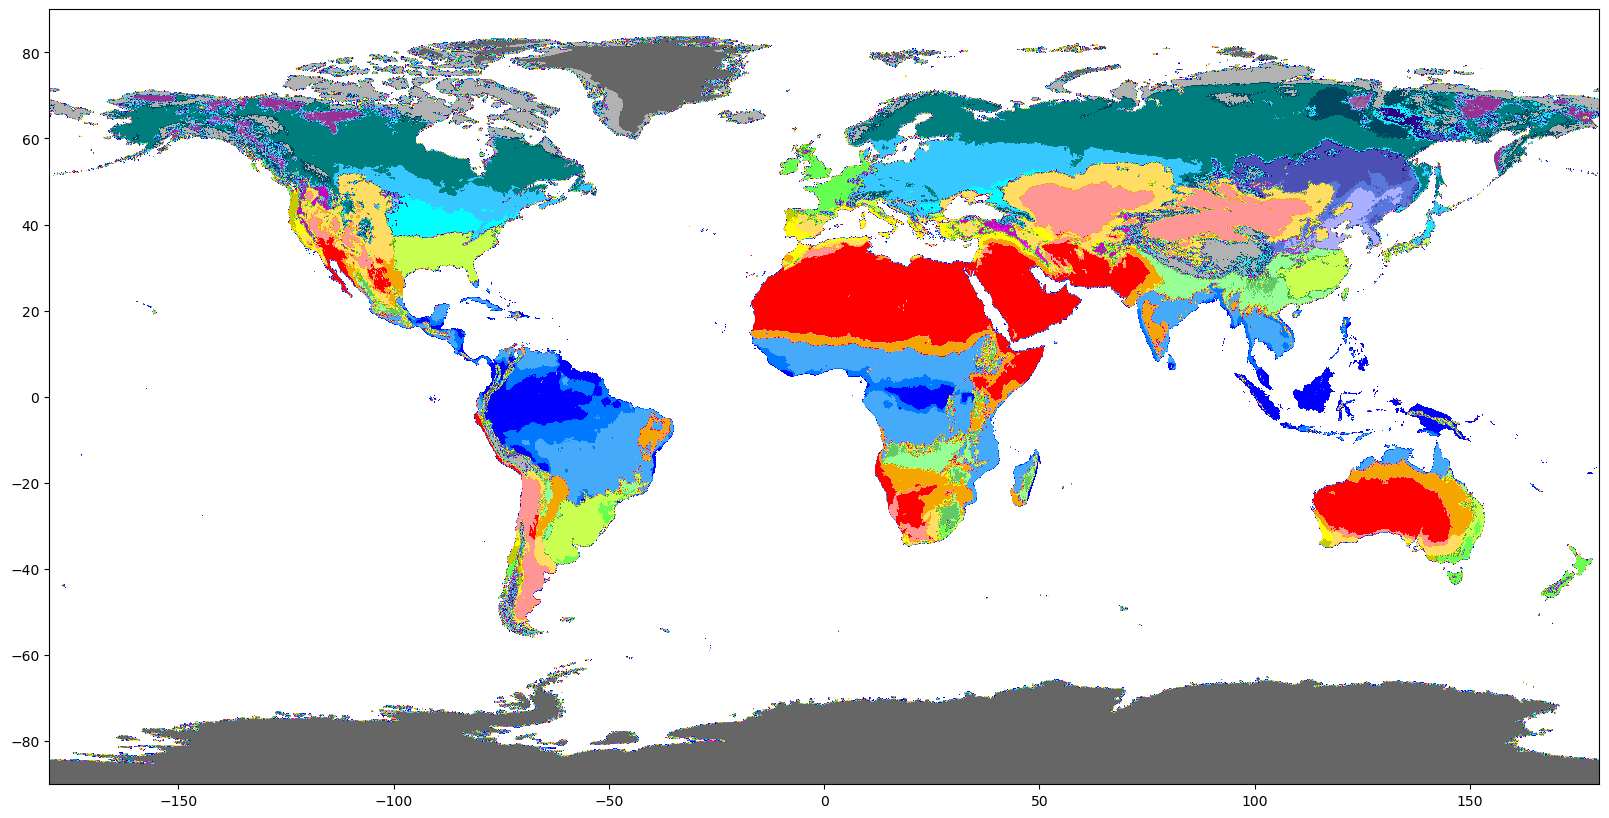

In [27]:
reg = re.compile('\[(.+)\]$')

with open('data/Beck_KG_V1/legend.txt','r') as f:
    rgba_vals = []
    rgba_vals.append([1.,1.,1.,1.])
    while line:=f.readline():
        if index_match := re.search(r'(\d+):', line): # Match 'num:'
            rgb_strings = re.search(reg, line)[1].split() # Match [...] and split list
            rgba = list(map(int, rgb_strings))
            rgba.append(255)
            rgba = [i/255 for i in rgba] 
            rgba_vals.append(rgba)

cmap = ListedColormap(rgba_vals)
src = rasterio.open('data/Beck_KG_V1/Beck_KG_V1_present_0p0083.tif')
fig, ax = plt.subplots(figsize=(20,16))
show(src, cmap = cmap, ax=ax)


There are a bunch of artefacts on the edges of boundaries, but overall it is a good match to the source image below (it is clear from the dark edges that they use some sort of smoothing when rendering the final image): ![source](data/Köppen-Geiger_Climate_Classification_Map.png)

Efficient raster to geopandas, from https://gis.stackexchange.com/questions/384581/raster-to-geopandas

In [28]:
raster_data = rxr.open_rasterio("data/Beck_KG_V1/Beck_KG_V1_present_0p083.tif")
raster_data.name = "Climate"
climate_df = raster_data.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(climate_df.x, climate_df.y)
climate_gdf = gpd.GeoDataFrame(climate_df, crs=raster_data.rio.crs, geometry=geometry)
# climate_gdf = climate_gdf.set_index('geometry')
# climate_gdf = climate_gdf['Climate']

In [29]:
climate_gdf.geometry

0          POINT (-179.95833 89.95833)
1          POINT (-179.87500 89.95833)
2          POINT (-179.79167 89.95833)
3          POINT (-179.70833 89.95833)
4          POINT (-179.62500 89.95833)
                      ...             
9331195    POINT (179.62500 -89.95833)
9331196    POINT (179.70833 -89.95833)
9331197    POINT (179.79167 -89.95833)
9331198    POINT (179.87500 -89.95833)
9331199    POINT (179.95833 -89.95833)
Name: geometry, Length: 9331200, dtype: geometry

In [30]:
city_climate_gdf = gpd.sjoin_nearest(city_gdf, climate_gdf)[['Climate','geometry']]
city_climate_gdf.head()

c:\ProgramData\Anaconda3\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,,Climate,geometry
Country,City,,
Afghanistan,Kabul,17,POINT (69.13700 34.53100)
Albania,Tirana,8,POINT (19.82000 41.33100)
Algeria,Algiers,8,POINT (3.03200 36.76600)
American Samoa,Pago Pago,1,POINT (-170.70300 -14.27800)
Angola,Luanda,6,POINT (13.23500 -8.81200)


In [31]:
city_climate_gdf.loc['Brazil']

,Climate,geometry
City,,
Brasília,3,POINT (-47.88800 -15.79400)
Manaus,1,POINT (-60.02300 -3.13500)
Recife,2,POINT (-34.88900 -8.06300)
Rio de Janeiro,3,POINT (-43.22800 -22.87700)
São Paulo,14,POINT (-46.57000 -23.56700)


### Adding economic data

We add economic data for GDP per capita (purchasing power parity), from the ![CIA world factbook](https://www.cia.gov/the-world-factbook/field/real-gdp-per-capita/country-comparison/)

In [32]:
with open('data/PPP.csv','r') as f:
    country_ppp_df = pd.read_csv(f, sep=';')

In [33]:
country_ppp_df.head()

,name,slug,value,date_of_information,ranking,region
0,Liechtenstein,liechtenstein,"$139,100",2009,1,Europe
1,Monaco,monaco,"$115,700",2015,2,Europe
2,Luxembourg,luxembourg,"$115,700",2021,3,Europe
3,Singapore,singapore,"$106,000",2021,4,East and Southeast Asia
4,Ireland,ireland,"$102,500",2021,5,Europe


In [34]:
country_ppp_df = country_ppp_df.set_index('name')
country_ppp_series = country_ppp_df['value']
country_ppp_series.index.name = 'Country'

In [35]:
city_climate_df = city_climate_gdf.reset_index(level=1) # Keep only countries in index
city_info_df = city_climate_df.merge(country_ppp_series, left_index=True, right_index=True, how='left')

Some values in the city_climate_df are not present in the PPP DF. This is likely due to naming ambiguity. It is fastest to just fix this by manually inspecting the dataset.

In [36]:
city_info_df[city_info_df.isna()['value']]

,City,Climate,geometry,value
Country,,,,
Cote D'Ivoire,Abidjan,2,POINT (-4.02600 5.32300),NaN
Democratic Republic of the Congo,Kinshasa,3,POINT (15.29800 -4.31600),NaN
Myanmar,Yangon,2,POINT (96.15000 16.79800),NaN
North Korea,Pyongyang,21,POINT (125.77600 39.01400),NaN
South Korea,Busan,14,POINT (129.10100 35.21500),NaN
South Korea,Seoul,21,POINT (126.97000 37.53700),NaN
Turkey,Istanbul,8,POINT (28.95800 41.01100),NaN


Eyeballing the PPP.csv file, we find the following substitutions

- Cote D'Ivoire -> Cote d'Ivoire
- Democratic Republic of the Congo -> Congo, Republic of the
- Myanmar -> Burma
- North Korea -> Korea, North
- South Korea -> Korea, South
- Turkey -> Turkey (Turkiye)

We can manually fix the data

In [37]:
missing_list =["Cote d'Ivoire", "Congo, Republic of the", "Burma", "Korea, North", "Korea, South", "Korea, South", "Turkey (Turkiye)"]

substitutions = country_ppp_series[missing_list].to_numpy()

In [38]:
country_ppp_series[missing_list].to_numpy()
sub_locations = city_info_df[city_info_df.isna()['value']].index.drop_duplicates()
city_info_df.loc[sub_locations,'value'] = substitutions
city_info_df.loc[sub_locations,'value']

Country
Cote D'Ivoire                        $5,300
Democratic Republic of the Congo     $3,200
Myanmar                              $4,000
North Korea                          $1,700
South Korea                         $44,200
South Korea                         $44,200
Turkey                              $31,500
Name: value, dtype: object

In [39]:
city_info_df['value'] = city_info_df['value'].replace('[\$,]', '', regex=True).astype(float) #dollar to float
city_info_df.columns = ['Location', 'Climate', 'Lat/Lon', 'GDP per capita (PPP)'] # clearer names
with open('data/city_info.csv','w') as f:
    city_info_df.to_csv(f)